# Trabajo de Fin de Master
Martín González López

## Inicialización

In [1]:
DATASET_FOLDER = "./datasets"
INPUT_NAME = "blur"
OUTPUT_NAME = "sharp"
IMAGES_FILES_FOLDER = "cache-images"

INPUT_NC = 3
INPUT_SHAPE = (720 // 5, 1280 // 5, INPUT_NC)

In [2]:
import glob
import os
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import keras
from keras.preprocessing.image import (
    load_img,
    img_to_array,
    array_to_img,
    ImageDataGenerator,
)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2021-08-25 10:42:22.079506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 10:42:22.085798: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 10:42:22.086210: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


## Dataset
Carga del dataset GOPRO y generación del dataset propio

In [4]:
def getLastComp(path):
    return path.split("/")[-1]


def getLastDir(path):
    return path.split("/")[-2]

In [5]:
datasets = glob.glob(os.path.join(DATASET_FOLDER, "*/"))

In [6]:
datasets = {getLastDir(x): x for x in datasets}

In [7]:
datasets

{'GOPRO': './datasets/GOPRO/'}

In [8]:
data_as_array = []  # Rellenar un array con los datos para crear un dataframe
for dataset_name, dataset_path in datasets.items():
    for type_path in glob.glob(os.path.join(dataset_path, "*/")):
        for secuence_path in glob.glob(os.path.join(type_path, "*/")):
            class_path = os.path.join(secuence_path, "blur")
            for frame_path in sorted(glob.glob(os.path.join(class_path, "*.png"))):
                data_as_array.append(
                    [
                        dataset_name,
                        getLastDir(type_path),
                        getLastDir(secuence_path),
                        int(getLastComp(frame_path).split(".")[0]),
                        frame_path,
                        frame_path.replace("blur", "sharp"),
                    ]
                )

In [9]:
dataframe = pd.DataFrame(
    data_as_array,
    columns=[
        "dataset",
        "type_name",
        "secuence",
        "frame_id",
        "blur_path",
        "sharp_path",
    ],
)

In [10]:
dataframe.head()

,dataset,type_name,secuence,frame_id,blur_path,sharp_path
0,GOPRO,test,GOPR0410_11_00,101,./datasets/GOPRO/test/GOPR0410_11_00/blur/0001...,./datasets/GOPRO/test/GOPR0410_11_00/sharp/000...
1,GOPRO,test,GOPR0410_11_00,102,./datasets/GOPRO/test/GOPR0410_11_00/blur/0001...,./datasets/GOPRO/test/GOPR0410_11_00/sharp/000...
2,GOPRO,test,GOPR0410_11_00,103,./datasets/GOPRO/test/GOPR0410_11_00/blur/0001...,./datasets/GOPRO/test/GOPR0410_11_00/sharp/000...
3,GOPRO,test,GOPR0410_11_00,104,./datasets/GOPRO/test/GOPR0410_11_00/blur/0001...,./datasets/GOPRO/test/GOPR0410_11_00/sharp/000...
4,GOPRO,test,GOPR0410_11_00,105,./datasets/GOPRO/test/GOPR0410_11_00/blur/0001...,./datasets/GOPRO/test/GOPR0410_11_00/sharp/000...


In [11]:
df_train = dataframe[dataframe["type_name"] == "train"]
df_test = dataframe[dataframe["type_name"] == "test"]

In [12]:
len(df_train)

2103

In [13]:
len(df_test)

1111

In [14]:
df_test.loc[0]

dataset                                                   GOPRO
type_name                                                  test
secuence                                         GOPR0410_11_00
frame_id                                                    101
blur_path     ./datasets/GOPRO/test/GOPR0410_11_00/blur/0001...
sharp_path    ./datasets/GOPRO/test/GOPR0410_11_00/sharp/000...
Name: 0, dtype: object

## Modelos

### Modelo Single Frame Deblurring

In [15]:
a = df_test.sample().blur_path.iloc[0]

In [16]:
b = load_img(a)

In [17]:
c = img_to_array(b)

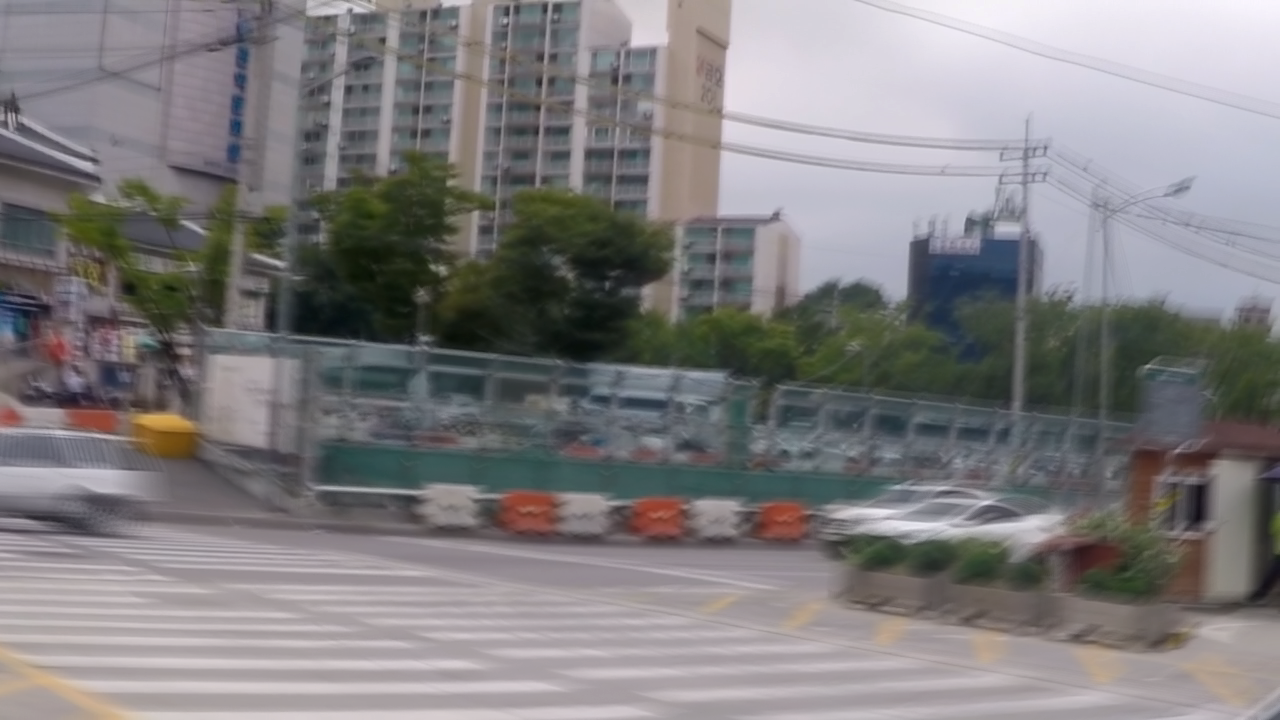

In [18]:
array_to_img(c)

In [19]:
from keras.layers import (
    Input,
    Conv2D,
    Activation,
    BatchNormalization,
    Conv2DTranspose,
    LeakyReLU,
    Flatten,
    Dense,
)
from keras.layers.core import Lambda, Dropout
from keras.layers.merge import Add
from keras.models import Model

In [20]:
def res_block(inputs, filters, kernel_size=3, strides=1, use_dropout=False):
    x = Conv2D(
        filters=filters, kernel_size=kernel_size, strides=strides, padding="same"
    )(inputs)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)

    merged = Add()([inputs, x])
    return merged

In [21]:
a = res_block(Input(shape=INPUT_SHAPE), 3)

2021-08-25 10:42:22.566764: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-25 10:42:22.567833: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 10:42:22.568159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-08-25 10:42:22.568417: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [22]:
a.shape

TensorShape([None, 144, 256, 3])

In [23]:
def generator_model():
    """Build generator architecture."""

    ngf = 4
    n_blocks_gen = 3

    inputs = Input(shape=INPUT_SHAPE)

    x = Conv2D(filters=ngf, kernel_size=(7, 7), padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # Increase filter number
    n_downsampling = 1
    for i in range(n_downsampling):
        mult = 2 ** i
        x = Conv2D(
            filters=ngf * mult * 2, kernel_size=(3, 3), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    # Apply 9 ResNet blocks
    mult = 2 ** n_downsampling
    for i in range(n_blocks_gen):
        x = res_block(x, ngf * mult, use_dropout=True)

    # Decrease filter number to 3 (RGB)
    for i in range(n_downsampling):
        mult = 2 ** (n_downsampling - i)
        x = Conv2DTranspose(
            filters=int(ngf * mult / 2), kernel_size=(3, 3), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)

    x = Conv2D(filters=INPUT_NC, kernel_size=(7, 7), padding="same")(x)
    x = Activation("tanh")(x)

    # Add direct connection from input to output and recenter to [-1, 1]
    outputs = Add()([x, inputs])
    outputs = Lambda(lambda z: z / 2)(outputs)

    model = Model(inputs=inputs, outputs=outputs, name="Generator")
    return model

In [24]:
def discriminator_model():
    """Build discriminator architecture."""
    n_layers = 3
    ndf = 8

    inputs = Input(shape=INPUT_SHAPE)

    x = Conv2D(filters=ndf, kernel_size=(4, 4), strides=2, padding="same")(inputs)
    x = LeakyReLU(0.2)(x)

    nf_mult, nf_mult_prev = 1, 1
    for n in range(n_layers):
        nf_mult_prev, nf_mult = nf_mult, min(2 ** n, 8)
        x = Conv2D(
            filters=ndf * nf_mult, kernel_size=(4, 4), strides=2, padding="same"
        )(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

    nf_mult_prev, nf_mult = nf_mult, min(2 ** n_layers, 8)
    x = Conv2D(filters=ndf * nf_mult, kernel_size=(4, 4), strides=1, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(filters=1, kernel_size=(4, 4), strides=1, padding="same")(x)

    x = Flatten()(x)
    x = Dense(1024, activation="tanh")(x)
    x = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=inputs, outputs=x, name="Discriminator")
    return model

In [25]:
def generator_containing_discriminator(generator, discriminator):
    inputs = Input(shape=INPUT_SHAPE)
    generated_image = generator(inputs)
    outputs = discriminator(generated_image)
    model = Model(inputs=inputs, outputs=[generated_image, outputs])
    return model

# Entrenamiento de Modelos

In [26]:
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras.applications.vgg16 import VGG16
from tqdm.notebook import tqdm

In [27]:
g = generator_model()
d = discriminator_model()

d_on_g = generator_containing_discriminator(g, d)

In [28]:
d_opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
d_on_g_opt = Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

In [29]:
vgg = VGG16(include_top=False, weights="imagenet", input_shape=INPUT_SHAPE)
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer("block3_conv3").output)
loss_model.trainable = False

def perceptual_loss(y_true, y_pred):
    return K.mean(K.square(loss_model(y_true) - loss_model(y_pred)))


def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [30]:
d.trainable = True
d.compile(optimizer=d_opt, loss=wasserstein_loss)
d.trainable = False
loss = [perceptual_loss, wasserstein_loss]
#loss = [wasserstein_loss]
loss_weights = [100, 1]
d_on_g.compile(optimizer=d_on_g_opt, loss=loss, loss_weights=loss_weights)
d.trainable = True

In [31]:
def image_to_path(image_id):
    return os.path.join(IMAGES_FILES_FOLDER, f'{image_id}.npy')

def image_is_in_cache(image_id):
    return os.path.isfile(image_to_path(image_id))

def get_image_from_cache(image_id):
    return np.load(image_to_path(image_id))

def save_image(image_id, np_array):
    return np.save(image_to_path(image_id), np_array)

def get_image(path, use_cache):
    def _get_image(path):
        image = load_img(path, target_size=INPUT_SHAPE)
        image = img_to_array(image)
        image = image / 127.5 - 1 # Hay que normalizar los datos para que, entre otras cosas, el transfer learning funcione
        return image
    if use_cache:
        image_id = path[2:-4].replace('/', '-')
        if image_is_in_cache(image_id):
            return get_image_from_cache(image_id)
        else:
            image = _get_image(path)
            save_image(image_id, image)
            return image
    else:
        return _get_image(path)


def get_images_from_array(path_array, use_cache=True):
    return np.array([get_image(x, use_cache) for x in path_array])

In [ ]:
batch_size = 16
epoch_num = 4
critic_updates = 5

output_true, output_false = np.ones((batch_size, 1)), -np.ones((batch_size, 1))

for epoch in tqdm(range(epoch_num)):
    df_train_len = len(df_train)
    permutated_indexes = np.random.permutation(df_train_len)

    d_losses = []
    d_on_g_losses = []
    for index in tqdm(range(int(df_train_len / batch_size))):
        batch_indexes = permutated_indexes[
            index * batch_size : (index + 1) * batch_size
        ]
        blur_batch = df_train.iloc[batch_indexes].blur_path.to_list()
        blur_batch = get_images_from_array(blur_batch)
        
        sharp_batch = df_train.iloc[batch_indexes].sharp_path.to_list()
        sharp_batch = get_images_from_array(sharp_batch)

        generated_images = g.predict(x=blur_batch, batch_size=batch_size)

        for _ in range(critic_updates):
            d_loss_real = d.train_on_batch(sharp_batch, output_true)
            d_loss_fake = d.train_on_batch(generated_images, output_false)
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            d_losses.append(d_loss)

        d.trainable = False

        d_on_g_loss = d_on_g.train_on_batch(
            blur_batch, [sharp_batch, output_true]
        )
        d_on_g_losses.append(d_on_g_loss)

        d.trainable = True

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/131 [00:00<?, ?it/s]

2021-08-25 10:44:01.147426: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8202
2021-08-25 10:44:03.317811: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-08-25 10:44:04.764125: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-25 10:44:04.764599: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-08-25 10:44:04.889825: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of 

In [ ]:
df_train_len / batch_size

In [ ]:
d2 = tf.image.resize(b, INPUT_SHAPE[:2])
array_to_img(d2)
array_to_img(
    tf.image.resize(
        d2,
        (720, 1280),
    )
)
None

In [ ]:
d_losses, d_on_g_losses

In [ ]:
a = df_train.iloc[batch_indexes[0]]

In [ ]:
b_i = a.blur_path
s_i = a.sharp_path

In [ ]:
test_image = load_img(b_i) 
test_image = tf.image.resize(test_image, INPUT_SHAPE)
display(test_image)
display(array_to_img(g.predict(b_i))
display(load_img(s_i))